# PyTorch vs Lightning
On [official PyTorch Lightning website](https://lightning.ai), there are mainly 2 introductory materials now(June 28, 2023, v2.0.4)  
- [colab notebook - hell pytorch lightning](https://colab.research.google.com/drive/1AZ5SM6zX13h4rOKxnIAYrg3N40fJFFQo?usp=sharing#scrollTo=HWB7-7yx-gxT)  
- [Document - Lightning in 15 minutes](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)  
As I'm not that familiar with both PyTorch and Lightning, I'm going to convert some model between them.  

# Exercise 1.
First, let's convert an autoencoder model on materials above(Both materials uses same model as an example). It encodes images from MNIST dataset as a 3-dimensional latent vector.
Let's just reproduce results.

In [5]:
import os, torch, torch.nn as nn, torch.utils.data as data, torchvision as tv
import lightning as L

encoder = nn.Sequential(nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 3))
decoder = nn.Sequential(nn.Linear(3, 128), nn.ReLU(), nn.Linear(128, 28 * 28))

class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder, self.decoder = encoder, decoder

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

dataset = tv.datasets.MNIST(".", download=True, transform=tv.transforms.ToTensor())

trainer = L.Trainer(max_steps=50000)
trainer.fit(LitAutoEncoder(encoder, decoder), data.DataLoader(dataset, batch_size=64))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 100 K 
1 | decoder | Sequential | 101 K 
---------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.810     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=50000` reached.


In [3]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir lightning_logs

In [32]:
# load checkpoint
checkpoint = "./lightning_logs/version_1/checkpoints/epoch=53-step=50000.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

# choose your trained nn.Module
encoder = autoencoder.encoder
encoder.eval()

# embed 4 fake images!
fake_image_batch = torch.Tensor(4, 28 * 28).cuda() # Original code without .cuda() raised an error - cuz there are two devices.
embeddings = encoder(fake_image_batch)
print("⚡" * 20, "\nPredictions (4 image embeddings):\n", embeddings, "\n", "⚡" * 20)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ 
Predictions (4 image embeddings):
 tensor([[ 3.2964e+31, -6.3957e+30,  2.7723e+30],
        [ 4.3791e+31,  2.2174e+31,  1.0365e+31],
        [ 7.7610e+29,  6.5145e+29, -3.0595e+29],
        [ 1.6289e+35,  2.5478e+35, -1.3249e+35]], device='cuda:0',
       grad_fn=<AddmmBackward0>) 
 ⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡


There were some problems so I had to add cuda() method on
```python
fake_image_batch = torch.Tensor(4, 28 * 28).cuda()
```  

## Visualization
This autoencoder can work as an image generator. Let's check out...

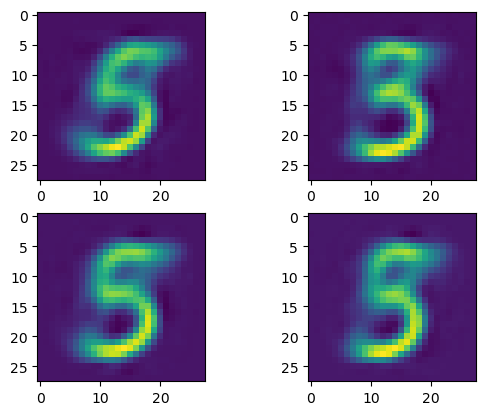

In [91]:
# regenerate fake images!
fake_image_batch = (torch.rand(4, 28*28)).cuda() # Original code without .cuda() raised an error - cuz there are two devices.
embeddings = encoder(fake_image_batch)

#import pyplot to plot
import matplotlib.pyplot as plt

# initialize decoder, 
decoder = autoencoder.decoder
decoder.eval()
gen_imgs = decoder(embeddings).cpu().detach().view(4,28,28).numpy()

plt.figure()
for i, subplot_index in enumerate([221, 222, 223, 224]):
    plt.subplot(subplot_index)
    plt.imshow(gen_imgs[i])

Let's plot comparison between input image and restored image. (an autoencoder model usually exhibits.)

type(X):<class 'torch.Tensor'>, type(y):<class 'torch.Tensor'>
size of X:torch.Size([4, 1, 28, 28]), y:torch.Size([4])
tensor([5, 0, 4, 1])


C:\Users\hms_l\AppData\Local\Temp\ipykernel_1760\3499559918.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(subplot_index)


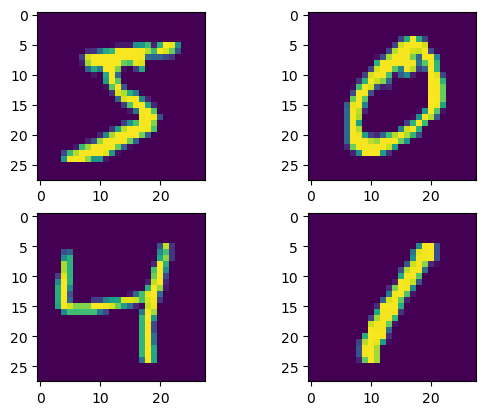

In [68]:
dataloader = data.DataLoader(dataset, batch_size=4)
for X, y in dataloader:
    print(f"type(X):{type(X)}, type(y):{type(y)}")
    print(f"size of X:{X.size()}, y:{y.size()}")
    print(y)
    X = X.view(4, 28, 28)
    
    plt.figure()
    plt.figure.title("input images")
    for i, subplot_index in enumerate([221, 222, 223, 224]):
        plt.subplot(subplot_index)
        plt.imshow(X[i])
    break

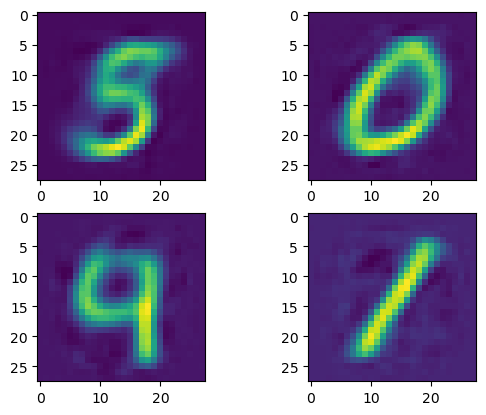

In [70]:
embeddings = encoder(X.view(4, 28*28).cuda())
gen_imgs = decoder(embeddings).cpu().detach().view(4,28,28).numpy()

plt.figure()
for i, subplot_index in enumerate([221, 222, 223, 224]):
    plt.subplot(subplot_index)
    plt.imshow(gen_imgs[i])